# TFM. Deep Visin applied to Real state.

https://docs.google.com/document/d/1z8G_THiNSHe14UcoJhIIcJL4NLlCuOiVTu6yvla37qo/edit#d


In [4]:
# google stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libraries

In [6]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# architecture 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
#from keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import Model

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# optimization
from tensorflow.keras.optimizers import Adam
from keras import regularizers
#from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2, l2

# pre-trained models
#from tensorflow.keras.applications import VGG16, ResNet50, VGG19

import os
import pickle
import tarfile

# counting classes with library
from collections import Counter

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

- base directory

In [7]:
!ls "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

 AlbertoVargas-sistema_clasificacion_viviendas_imagenes.gslides
'Dudas y seguimiento TFM.gdoc'
 input
 output
'performance of NN.gdoc'
 src


In [8]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

- functions

In [9]:
# insert the directory
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD#, Adam

from my_functions import freezing_layers, vgg16_19_conf, resnet50_conf, nn_parameters, plotting_model, generic_last_2layers
from datetime import datetime

# load pickling data allocated in Drive

In [11]:
with open(input_folder+"pickle_all_images_df.pickle", "rb") as input_file:
    data_x = pickle.load(input_file)
with open(input_folder+"pickle_all_classes.pickle", "rb") as input_file:
    data_y = pickle.load(input_file)

- some preview

In [12]:
print(Counter(data_y))

Counter({'Livingroom': 1273, 'Bedroom': 1248, 'Dinning': 1158, 'Kitchen': 965, 'Bathroom': 606})


In [13]:
classes_list = list(Counter(data_y).keys())

- i'll have to deal with this unbalanced classes later. 
- let's begin with the simplest stuff first

In [14]:
print("pics shape: ",data_x.shape,
      "\nnumber of classes: ", len(set(data_y))
      )

pics shape:  (5250, 128, 128, 3) 
number of classes:  5


Dinning


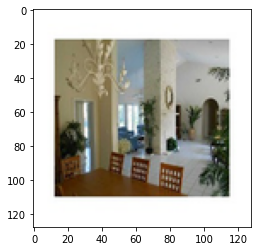

In [15]:
# # showing some stuff 
print(data_y[42])
imgplot = plt.imshow(data_x[42])
plt.show()

- transforming y-label into numeric

In [16]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

In [17]:
test_size_1st_split = 0.3
test_size_2nd_split= 0.5

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y_num, test_size=test_size_1st_split)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size_2nd_split) 
allx= len(data_x)
print(round(len(x_train)/allx,2), round(len(x_val)/allx,2), round(len(x_test)/allx,2))
del data_y
del data_x

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

0.7 0.15 0.15


In [18]:
print("train:  ", x_train.shape, y_train.shape,
      "\ntest: ", x_test.shape,y_test.shape,
      "\nval:  ", x_val.shape, y_val.shape)

train:   (3675, 128, 128, 3) (3675, 5) 
test:  (788, 128, 128, 3) (788, 5) 
val:   (787, 128, 128, 3) (787, 5)


In [19]:
#Data Augmentation first
# antes sólo rotation_angle=2, horizontal_flip=True, zoom_range=.1
train_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip=True, zoom_range=.1)
val_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip= True, zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

# entrenar todos los modelos  con una misma configuración

In [26]:
#Initializing the hyperparameters
batch_size= 128
epochs=200
#sgd=SGD(learning_rate=.01,momentum=.9,nesterov=False)
#sgd=Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_type='categorical_crossentropy'

In [21]:
from tensorflow.keras.applications import Xception, InceptionResNetV2, DenseNet121

In [22]:
pre_trained_vgg16 = vgg16_19_conf("vgg16",5, True, 0.2, y_train)
pre_trained_vgg19 = vgg16_19_conf("vgg16",5, True, 0.2, y_train)
pre_trained_resnet50 = resnet50_conf(5, True, 0.2, y_train)

pre_trained_xception= generic_last_2layers(
    Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, False, 0.2, y_train)

pre_trained_xception_drop= generic_last_2layers(
    Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, True, 0.2, y_train)

pre_trained_inception= generic_last_2layers(
    InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, False, 0.2, y_train)

pre_trained_inception_drop= generic_last_2layers(
    InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, True, 0.2, y_train
    )
# pre_trained_densenet= generic_last_2layers(
#     DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
#     5, False, 0.2, y_train
#     )
# pre_trained_densenet_drop= generic_last_2layers(
#     DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
#     5, True, 0.2, y_train
#     )

models = [#pre_trained_vgg16, 
          #pre_trained_vgg19, 
          #pre_trained_resnet50,
          pre_trained_xception,
          pre_trained_xception_drop,
          pre_trained_inception,
          pre_trained_inception_drop,
          ]

def naming_model(model):
  '''gives a name to save it after training'''
  if model== pre_trained_vgg16:
    name = "vgg16-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
  elif model == pre_trained_vgg19:
    name = "vgg19-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
  elif model == pre_trained_resnet50:
    name = "resnet50-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_xception:
    name = "xception-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_xception_drop:
    name = "xception_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_inception:
    name = "InceptionResNetV2-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_inception_drop:
    name = "InceptionResNetV2_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  return name

219070464/219055592 [==============================] - 3s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
28/28 - 25s - loss: 1.1324 - accuracy: 0.5413 - val_loss: 1.1543 - val_accuracy: 0.5273
Epoch 2/2
28/28 - 21s - loss: 1.0891 - accuracy: 0.5670 - val_loss: 1.1244 - val_accuracy: 0.5482


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


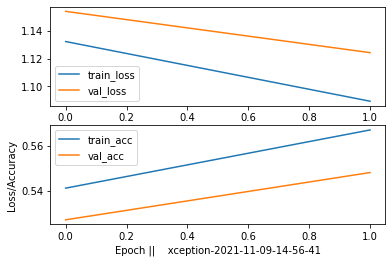

[INFO]: Model godness...
epochs:  2 
               precision    recall  f1-score   support

     Dinning       0.73      0.64      0.69        95
     Bedroom       0.67      0.60      0.63       184
  Livingroom       0.73      0.53      0.61       179
     Kitchen       0.60      0.62      0.61       154
    Bathroom       0.42      0.59      0.49       176

    accuracy                           0.59       788
   macro avg       0.63      0.60      0.61       788
weighted avg       0.62      0.59      0.60       788



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2


KeyboardInterrupt: ignored

In [27]:
monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=10,mode='auto',verbose=1, restore_best_weights=True)
#monitor= ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=3, min_lr=1e-4) # "val_acc " warning

for model in models:
  
  model.compile(optimizer = "adam", loss=loss_type ,metrics=['accuracy'])
  model_result= model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size= batch_size),
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[monitor], 
    verbose = 2
    )
  
  number_of_epochs_it_ran = len(model_result.history['loss']) 
  name = naming_model(model)
  model.save(output_folder+name+".h5")

  plotting_model(model_result,number_of_epochs_it_ran, name)

  #Evaluatin
  print("[INFO]: Model godness...")
  y_pred = model.predict(x_test, batch_size=128)
  y_true=np.argmax(y_test,axis=1)
  print("epochs: ", number_of_epochs_it_ran, "\n",
      classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list )
      )

# VGG16
https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

last layers of vgg16 are 2 dense layers of 4096 neurons and a last one of 1000 neurons (to classify 1000 different classes)
https://miro.medium.com/max/470/1*3-TqqkRQ4rWLOMX-gvkYwA.png

So, we'll do:
- load all layers but the top model (last 3 dense layers). this will be the base model
- freeze layers of base model (saving how they're trained)
- we want to copy the vgg16 architecture, so we have to add manually the last layers: we'll add 2 dense layers of 4096 and change the last one designed to classifty 1000 classes for a 5-neurons layer.


In [ ]:
from keras.callbacks import ReduceLROnPlateau
#from tensorflow.keras.optimizers import SGD#, Adam

In [ ]:
#test = VGG16(include_top=True)
#test.summary()

In [ ]:
# no incluyo el top (las últimas capas dense, que añado al final)
base_model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax')
pre_trained_vgg16 = Sequential() # to add more stuff

'''
antes lo añadía todo menos la última capa, pero como estamos trabajando sin el top model, no es necesario, las 2 últimas capas no están
(base model acaba en block5_pool (MaxPooling2D) )
'''
for layer in base_model_vgg16.layers:#[:-1]: # not loading the last layer
    pre_trained_vgg16.add(layer)    

# Freeze the layers 
for layer in pre_trained_vgg16.layers:
    layer.trainable = False

# before the final layer has the shape (None, 8, 8, 5). I do need (0, 5)
pre_trained_vgg16.add(Flatten())

# emulating vgg16 architecture (but we'll train on this layers)
pre_trained_vgg16.add(Dense(4096,activation=('relu')))
pre_trained_vgg16.add(Dense(4096,activation=('relu'))) 
pre_trained_vgg16.add(Dense(5,activation=('softmax'))) 
pre_trained_vgg16.summary()
print(len(pre_trained_vgg16.layers))

**training**

- callbacks
  - reducelronplateau - monitor the validation accuracy and if it seems to be a plateau in 3 epochs, it will reduce the learning rate by 0.01.
  - Learning Rate Annealer - decreases the learning rate after a certain number of epochs if the error rate does not change. Here, through this technique
- optimizers
  - crossentroty: logaritmic metric from 0.99 (terrible) to 0 (too much perfect)=> https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/


In [ ]:
lrr= ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=3, min_lr=1e-4) # "val_acc " warning
#https://keras.io/api/callbacks/early_stopping/
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
#Initializing the hyperparameters
batch_size= 128
epochs=200
learn_rate=.01
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
pre_trained_vgg16.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'] )

In [ ]:
#Training the model - al usar esta config no tengo un array de val_accuracy, val_loss https://stackoverflow.com/questions/55746382/why-val-loss-and-val-acc-are-not-displaying
model_vgg16= pre_trained_vgg16.fit_generator(
    train_generator.flow(x_train, y_train, batch_size= batch_size),
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[lrr], 
    verbose = 1
    )

In [ ]:
#save model (before fit_generator)
name = "vgg16_20211010"
pre_trained_vgg16.save(output_folder+name+".h5")

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(np.arange(0, epochs), model_vgg16.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), model_vgg16.history["val_loss"], label="val_loss")
ax[0].legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), model_vgg16.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), model_vgg16.history["val_accuracy"], label="val_acc")
ax[1].legend()
plt.xlabel("Epochs    #"+"-- "+name+"--")
plt.ylabel("Loss/Accuracy")

In [ ]:
#Evaluatin
print("[INFO]: Model godness...")
y_pred = pre_trained_vgg16.predict(x_test, batch_size=128)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list ))

In [ ]:
# no incluyo el top (las últimas capas dense, que añado al final)
base_model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax')
pre_trained_vgg16 = Sequential() # to add more stuff

'''
antes lo añadía todo menos la última capa, pero como estamos trabajando sin el top model, no es necesario, las 2 últimas capas no están
(base model acaba en block5_pool (MaxPooling2D) )
'''
for layer in base_model_vgg16.layers:#[:-1]: # not loading the last layer
    pre_trained_vgg16.add(layer)    

# Freeze the layers 
for layer in pre_trained_vgg16.layers:
    layer.trainable = False

# before the final layer has the shape (None, 8, 8, 5). I do need (0, 5)
pre_trained_vgg16.add(Flatten())

# emulating vgg16 architecture (but we'll train on this layers)
pre_trained_vgg16.add(Dense(4096,activation=('relu')))
pre_trained_vgg16.add(Dense(4096,activation=('relu'))) 
pre_trained_vgg16.add(Dense(5,activation=('softmax'))) 
pre_trained_vgg16.summary()
print(len(pre_trained_vgg16.layers))

# VGG19

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD#, Adam

In [ ]:
# test = VGG19(include_top = True)
# test.summary()

In [ ]:
# no incluyo el top (las últimas capas dense, que añado al final)
base_model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax')
pre_trained_vgg19 = Sequential() # to add more stuff

for layer in base_model_vgg19.layers:
    pre_trained_vgg19.add(layer)    

# Freeze the layers 
for layer in pre_trained_vgg16.layers:
    layer.trainable = False

# before the final layer has the shape (None, 8, 8, 5). I do need (0, 5)
pre_trained_vgg19.add(Flatten())

# emulating vgg16 architecture (but we'll train on this layers)
pre_trained_vgg19.add(Dense(4096,activation=('relu')))
pre_trained_vgg19.add(Dense(4096,activation=('relu'))) 
pre_trained_vgg19.add(Dense(5,activation=('softmax'))) 
pre_trained_vgg19.summary()
print(len(pre_trained_vgg16.layers))

In [ ]:
lrr= ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=3, min_lr=1e-4) # "val_acc " warning
#https://keras.io/api/callbacks/early_stopping/
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
#Initializing the hyperparameters
batch_size= 128
epochs=200
learn_rate=.01
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
pre_trained_vgg19.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'] )

In [ ]:
#Training the model - al usar esta config no tengo un array de val_accuracy, val_loss https://stackoverflow.com/questions/55746382/why-val-loss-and-val-acc-are-not-displaying
model_vgg19= pre_trained_vgg19.fit_generator(
    train_generator.flow(x_train, y_train, batch_size= batch_size),
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[lrr], 
    verbose = 1
    )

In [ ]:
#save model (before fit_generator)
name = "vgg19_20211107"
pre_trained_vgg16.save(output_folder+name+".h5")

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(np.arange(0, epochs), model_vgg19.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), model_vgg19.history["val_loss"], label="val_loss")
ax[0].legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), model_vgg19.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), model_vgg19.history["val_accuracy"], label="val_acc")
ax[1].legend()
plt.xlabel("Epochs    #"+"-- "+name+"--")
plt.ylabel("Loss/Accuracy")

In [ ]:
#Evaluatin
print("[INFO]: Model godness...")
y_pred = pre_trained_vgg19.predict(x_test, batch_size=128)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list ))

------------------------------------

# resnet50

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50


let's 
-  not loading the top model, create it and modify the last layer to have 5 neurons for our 5 classes (this is done loading all but last layer).
- the difference between loading or not the mop model consists of 2 layers:
  - avg_pool (GlobalAveragePooling2 (None, 2048)
  - predictions (Dense)             (None, 1000) **-5 in our case because we have to infer 5 different classes-**
  So we'll load it without the top model and later add this 2 layers.
- freeze layers
- Estaba teniendo problemas con establecer Sequential() con la resnet. antes lo hacía como la primera celda muteada y daba error. abajo me sale bien, no entiendo muy bien por qué todavía (otra forma de ordenar capas)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD#, Adam

In [ ]:
# resnet50 = ResNet50()
# resnet50.summary()

# resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax')
# resnet50.summary()

In [ ]:
pre_trained_resnet50 = Sequential()
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
pre_trained_resnet50.add(ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'))

# Freeze the layers 
for layer in pre_trained_resnet50.layers:
    layer.trainable = False

# https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
pre_trained_resnet50.add(GlobalAveragePooling2D())

#añadimos el top model
'''la última capa es la de 1000 neuronas y la estoy sustituyendo por la mía de 5'''
#pre_trained_resnet50.add(Dense(1024,activation=('softmax'))) 
pre_trained_resnet50.add(Dense(5,activation=('softmax'))) 
pre_trained_resnet50.summary()

- training

In [ ]:
lrr= ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=3, min_lr=1e-4) # "val_acc " warning
#https://keras.io/api/callbacks/early_stopping/
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
#Initializing the hyperparameters
batch_size= 128
epochs=200
learn_rate=.01
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
pre_trained_resnet50.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'] )

In [ ]:
#Training the model - al usar esta config no tengo un array de val_accuracy, val_loss https://stackoverflow.com/questions/55746382/why-val-loss-and-val-acc-are-not-displaying

model_resnet50= pre_trained_resnet50.fit_generator(
    train_generator.flow(x_train, y_train, batch_size= batch_size),
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[lrr], 
    verbose = 1
    )

In [ ]:
#save model (before fit_generator)
pre_trained_resnet50.save(output_folder+"resnet50-2021-11-06.h5")

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(np.arange(0, epochs), model_resnet50.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), model_resnet50.history["val_loss"], label="val_loss")
ax[0].legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), model_resnet50.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), model_resnet50.history["val_accuracy"], label="val_acc")
ax[1].legend()
#plt.legend()
#plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

In [ ]:
#Evaluatin
print("[INFO]: Model godness...")
y_pred = pre_trained_resnet50.predict(x_test, batch_size=128)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list ))